# M2: Unsupervised archetype analysis

Follows Notebook 1b, where we added information to match this analysis with Debbie's.

In [2]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
# make sure to use position 1
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb
import cellrank as cr
import scanorama
from scipy.spatial.distance import squareform
from scipy.sparse import issparse, csr_matrix, find
from scipy.spatial.distance import pdist
from py_pcha import PCHA
from sklearn.utils import shuffle
from matplotlib.colors import CenteredNorm

In [2]:
adata = sc.read_h5ad('../../data/M2/adata_01_filtered.h5ad')

In [79]:
adata

AnnData object with n_obs × n_vars = 4388 × 15728
    obs: 'doublet_scores', 'predicted_doublets', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_score1', 'comb.score', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'wsnn_res.0.5', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mito', 'pct_dropout_by_counts', 'amb

## MAGIC

For stronger PCHA, we'll run MAGIC.

In [4]:
import magic
# import pandas as pd
# import matplotlib.pyplot as plt
magic_operator = magic.MAGIC(solver='approximate')
X_magic = magic_operator.fit_transform(adata)


Calculating MAGIC...
  Running MAGIC on 4388 cells and 15728 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/Users/smgroves/Documents/anaconda3/envs/multiome/lib/python3.9/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 1.70 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.71 seconds.
    Calculating affinities...
    Calculated affinities in 1.90 seconds.
  Calculated graph and diffusion operator in 5.32 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 5.88 seconds.


In [5]:
sc.pp.pca(X_magic)

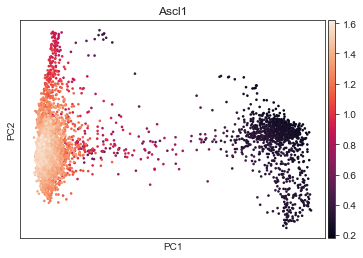

In [6]:
sc.pl.pca(X_magic, color='Ascl1')

In [7]:
scv.pp.neighbors(X_magic, random_state=0)
scv.tl.umap(X_magic, random_state=0)

computing neighbors


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


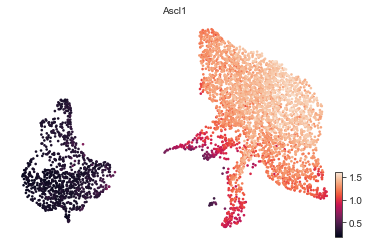

In [8]:
scv.pl.umap(X_magic, color = 'Ascl1')

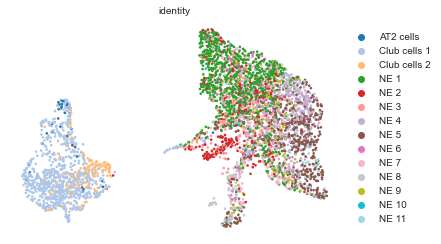

In [9]:
scv.pl.umap(X_magic, color = 'identity', legend_loc = 'on right', palette='tab20')

In [11]:
X_magic

AnnData object with n_obs × n_vars = 4388 × 15728
    obs: 'doublet_scores', 'predicted_doublets', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_score1', 'comb.score', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'wsnn_res.0.5'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mito', 'pct_dropout_by_counts', 'ambient'
    uns: 'pca', 'neigh

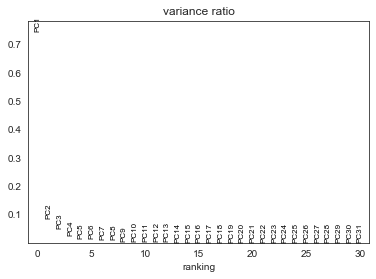

In [10]:
sc.pl.pca_variance_ratio(X_magic)

In [12]:
pca_var = X_magic.uns['pca']['variance_ratio']
var_explained = .90
tot_exp_var = 0
n = 0
for i in pca_var:
    n +=1
    tot_exp_var += i
    if tot_exp_var > var_explained: 
        print(n+1, "PCs explain at least", var_explained*100, "percent of the variance")
        break

5 PCs explain at least 90.0 percent of the variance


In [13]:
def cumulative(var):
    cum_var = []
    tot_sum = 0
    for i in var:
        tot_sum += i
        cum_var.append(tot_sum)
    return cum_var


In [14]:
cum_var = cumulative(pca_var)
cum_var[7]

0.9557057078927755

In [15]:
def find_knee_varexpl(cum_var):
    farthestk = 0
    for i in range(50):
        #find distance of point p3 from line between p1 and p2
        p1=np.array([0,cum_var[0]])
        p2=np.array([49,cum_var[49]])
        p3=np.array([i,cum_var[i]])
        k = (np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

        #knee is farthest away from line between p1 and p2
        if k > farthestk: 
            farthestk = k
            knee = i
    return knee +1 # number of components is 1 more than index
print("Knee of EV vs PC plot: ",find_knee_varexpl(cum_var))

Knee of EV vs PC plot:  8


In [16]:
X_magic.write_h5ad('../../data/M2/X_magic_02.h5ad')

## PCHA 

In [ ]:
!pip install py_pcha

In [17]:
def find_knee(ev_per_arc, kmax):
    farthestk = 0
    for i in range(3,kmax):
        #find distance of point p3 from line between p1 and p2
        p1=np.array([3,ev_per_arc[0]])
        p2=np.array([kmax,ev_per_arc[kmax-3]])
        p3=np.array([i,ev_per_arc[i-3]])
        k = (np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

        #knee is farthest away from line between p1 and p2
        if k > farthestk: 
            farthestk = k
            knee = i
    print("K* =",knee, "archetypes, distance between k* and line: ",np.round(farthestk,2))
    return knee, farthestk

# PCHA on data without doublets

In [ ]:
# pca_var = X_magic_no_doublets.uns['pca']['variance_ratio']
# cum_var = cumulative(pca_var)

# print("Knee of EV vs PC plot: ",find_knee_varexpl(cum_var))

0.824024014705455
0.8732600811427987
0.8948130118749108
0.9075248050315567
0.9255790294403481
0.9349840486768639
0.9382282371359922
0.9401454206950224
Knee in EV vs k plot for different k_max:
k_max = 8
K* = 4 archetypes, distance between k* and line:  0.03
k_max = 9
K* = 5 archetypes, distance between k* and line:  0.03
k_max = 10
K* = 5 archetypes, distance between k* and line:  0.04


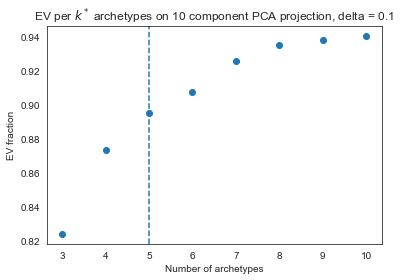

In [18]:
ev_per_arc = []
for i in range(3,11):
    XC, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'].T, noc=i, delta=0.1)
    ev_per_arc.append(varexpl)
    print(varexpl)
plt.scatter(x = [3,4,5,6,7,8,9,10], y = ev_per_arc)
plt.title(f"EV per $k^*$ archetypes on 10 component PCA projection, delta = 0.1")
plt.xlabel("Number of archetypes")
plt.ylabel("EV fraction")
print("Knee in EV vs k plot for different k_max:")
for kmax in range(8,11):
    print('k_max =', kmax)
    knee, farthestk = find_knee(ev_per_arc, kmax=kmax)
plt.axvline(x=knee, linestyle = "--")
plt.show()

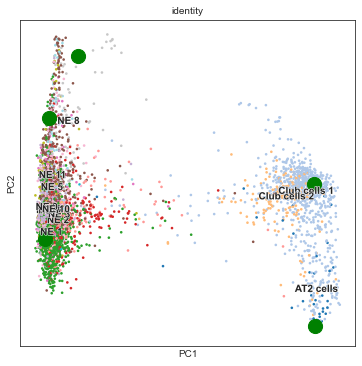

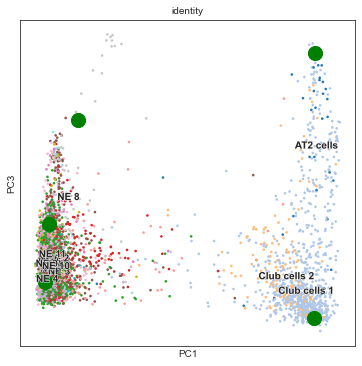

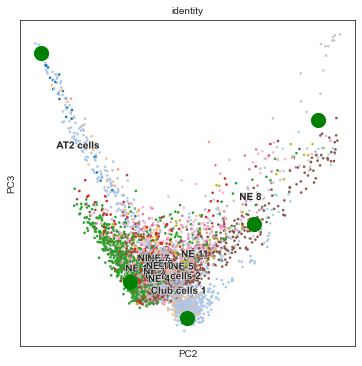

In [20]:
XC, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'][:,0:8].T, noc=5, delta=0)
XC = np.array(XC)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'identity', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC[int(comp[0])-1], XC[int(comp[1])-1], color = 'green', s = 200)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

In [22]:
# adata_U, umap = mb.pl.umap_update(adata, copy=True, method = "umap_original")

In [57]:
# XC_umap = umap.transform(XC.T).T


In [59]:
# sc.pl.scatter(adata_U, basis = 'umap_orig', color = "identity",show=False, frameon=True)
# plt.scatter(XC_umap[0], XC_umap[1], color = 'green', s = 200)
# plt.show()


## Labeling cells based on diffusion distance to archetypes
From Van Dijk et al:
An archetype is a weighted sum of cells, which allows us to construct archetypal-neighborhoods, consisting of cells most similar to the archetype. The neighborhoods are constructed by assigning cells to their nearest archetype based on the diffusion distance, as long as this distance is within a bounded proximity from the archetype. Diffusion distance is defined as the Euclidean distance on the diffusion map representation of the data, i.e., using diffusion components as a coordinate system (Nadler et al., 2006), denoted by DM(t).

In [60]:
XC_df = pd.DataFrame(XC)
XC_df.columns = ['Arc_1','Arc_2','Arc_3','Arc_4','Arc_5']


In [61]:
X_magic_pca_df = pd.DataFrame(X_magic.obsm['X_pca'][:,0:8], index = X_magic.obs_names)
X_magic_full_df = X_magic_pca_df.append(XC_df.T)
X_magic_full_df.head()

,0,1,2,3,4,5,6,7
gex_possorted_bam_1WGCZ:AAATGGCCATTGTCAGx,-1.309754,-0.058398,0.591664,0.522987,0.140917,-0.307722,-0.082273,-0.233697
gex_possorted_bam_1WGCZ:AACATTGTCTAGCGATx,4.453922,0.224103,-0.696261,-0.218195,0.945540,0.053669,0.469943,0.353156
gex_possorted_bam_1WGCZ:AAAGGACGTAGACAAAx,-1.453251,-0.969158,0.386985,0.151808,-0.049536,-0.421554,-0.012539,0.078885
gex_possorted_bam_1WGCZ:AAAGCACCAATTGCGCx,-1.533841,-0.161343,0.240549,-0.391598,-0.049783,-0.021242,0.057799,0.060382
gex_possorted_bam_1WGCZ:AAACCAACAAGCTTATx,5.179357,-1.213685,1.187651,0.147941,-0.984184,-0.033734,-0.004518,0.037342


In [62]:
pdx = squareform(pdist(X_magic_full_df, metric='euclidean')) # compute distances on pca
pdx_df = pd.DataFrame(pdx, index=X_magic_full_df.index, columns=X_magic_full_df.index)
pdx_df = pdx_df.loc[XC_df.columns].drop(XC_df.columns, axis = 1)
X_magic.obsm['arc_distance'] = pdx_df.T

Now that we have a euclidean distance to each archetype on the MAGIC imputed data, we can find a neighborhood with arbritrary radius to classify cells closest to each archetype as specialists. In Van Dijk et al., they choose a radius (distance on diffusion map) that is 1/2 the minimum of the distance between archetypes.

In [63]:
pdx_archetypes = squareform(pdist(XC_df.T, metric='euclidean')) # compute distances on pca

radius = .5*pdx_archetypes[pdx_archetypes > 0].min()

In [64]:
tmp = X_magic.obsm['arc_distance'].copy()

In [65]:
# percent_radius = .1 # in percentage of datapoints; radius = .1 means 10% closest cells to each archetype

for arc in  X_magic.obsm['arc_distance'].columns:
    closest = X_magic.obsm['arc_distance'].loc[X_magic.obsm['arc_distance'][arc].sort_values() < radius]
    tmp.loc[closest.index,'specialist'] = arc


In [66]:
tmp.specialist

gex_possorted_bam_1WGCZ:AAATGGCCATTGTCAGx    Arc_1
gex_possorted_bam_1WGCZ:AACATTGTCTAGCGATx    Arc_3
gex_possorted_bam_1WGCZ:AAAGGACGTAGACAAAx    Arc_1
gex_possorted_bam_1WGCZ:AAAGCACCAATTGCGCx    Arc_1
gex_possorted_bam_1WGCZ:AAACCAACAAGCTTATx      NaN
                                             ...  
gex_possorted_bam_1WGCZ:TTTGTGTTCCTTAGGGx      NaN
gex_possorted_bam_1WGCZ:TTTGTGGCATGGCCCAx    Arc_1
gex_possorted_bam_1WGCZ:TTTGTGTTCGGCCATAx      NaN
gex_possorted_bam_1WGCZ:TTTGTTGGTCAAAGAAx    Arc_1
gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx    Arc_1
Name: specialist, Length: 4388, dtype: object

In [67]:
X_magic.obs['specialists_pca_diffdist'] = tmp.specialist

## Labeling by PCHA

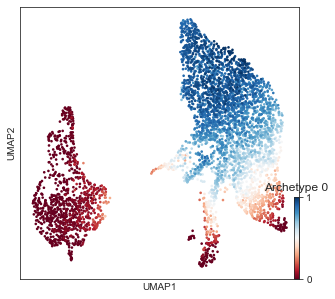

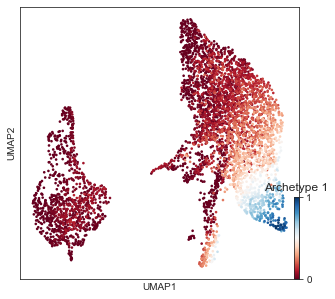

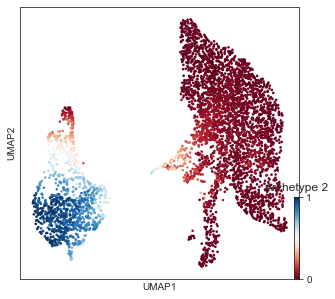

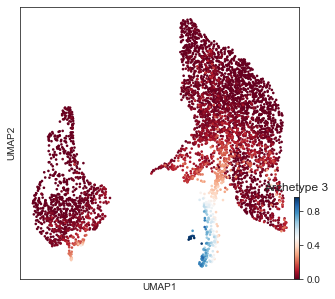

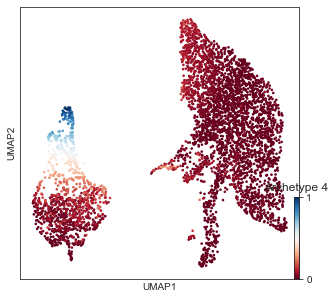

In [68]:
for i in range(5):
    scv.pl.umap(X_magic, c = S[i,:].T, components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu')
    plt.title(f"Archetype {i}")
    plt.savefig(f'./figures/unsupervised_AA/{i}_scPCHA_pca.pdf')

In [69]:
S_df = pd.DataFrame(S.T)

In [70]:
S_df.index = X_magic.obs_names

In [71]:
X_magic.obsm['py_pcha_S'] = S.T

In [72]:
X_magic

AnnData object with n_obs × n_vars = 4388 × 15728
    obs: 'doublet_scores', 'predicted_doublets', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_score1', 'comb.score', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'wsnn_res.0.5', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mito', 'pct_dropout_by_counts', 'amb

In [80]:
adata

AnnData object with n_obs × n_vars = 4388 × 15728
    obs: 'doublet_scores', 'predicted_doublets', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_score1', 'comb.score', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'wsnn_res.0.5', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mito', 'pct_dropout_by_counts', 'amb

In [81]:
adata.obsm['arc_distance'] = pdx_df.T

In [90]:
S_df.columns = ['Arc_1','Arc_2','Arc_3','Arc_4','Arc_5']

In [92]:
adata.obsm['py_pcha_S'] = S_df

In [97]:
for c in adata.obsm['py_pcha_S']:
    adata.obs[f"{c}_PCHA_Score"] = adata.obsm['py_pcha_S'][c]

<AxesSubplot:title={'center':'Arc 1 PCHA Score'}, xlabel='umap_wnn1', ylabel='umap_wnn2'>

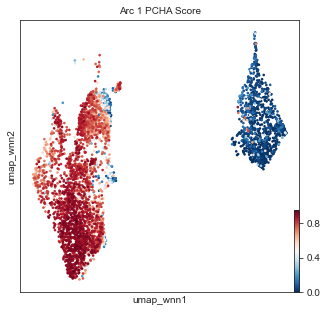

In [98]:
scv.pl.scatter(adata, c = "Arc_1_PCHA_Score", basis = "umap_wnn",components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', smooth = True)


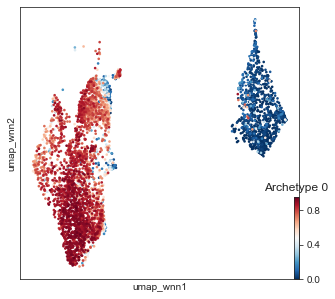

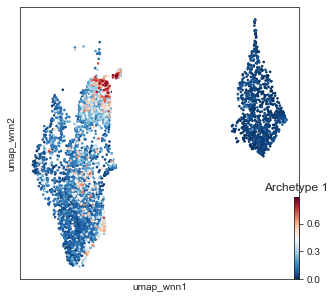

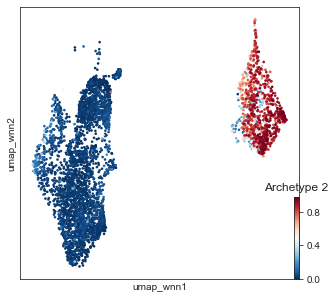

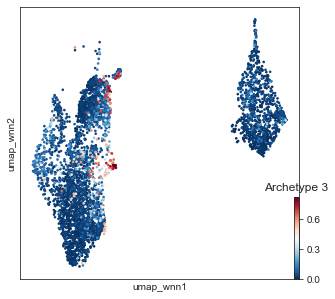

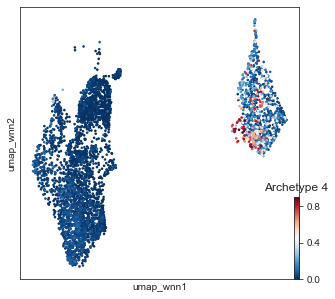

In [78]:
for i in range(5):
    scv.pl.scatter(adata, c = S[i,:].T, basis = "umap_wnn",components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', smooth = True)
    plt.title(f"Archetype {i}")
    plt.show()

# Write out data

In [99]:
adata.write_h5ad('../../data/M2/adata_02_filtered.h5ad')

In [100]:
X_magic.write_h5ad("../../data/M2/X_magic_02_filtered.h5ad")

## Write out data for ParetoTI 
T ratio calculation and comparison of single cell archetypes to bulk archetypes using enrichments


We will run archetype analysis using ParetoTI, and compare the single cell and bulk archetypes using the Hausser code (hypergeometric tests on enrichments). We will use the PCA of the MAGIC imputed data.

In [53]:
X_magic_for_R = X_magic.copy()

In [54]:
X_magic_for_R

AnnData object with n_obs × n_vars = 4388 × 15728
    obs: 'doublet_scores', 'predicted_doublets', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_score1', 'comb.score', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'wsnn_res.0.5'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 

In [55]:
#Get rid of arc_distance, which causes a problem in R
X_magic_for_R.obsm = {'X_pca':X_magic_for_R.obsm['X_pca']}

In [56]:
# for col in ['specialists_pca_diffdist']:
#     X_magic_for_R.obs[col]=X_magic_for_R.obs[col].cat.add_categories("Unknown").fillna('Unknown')

In [57]:
X_magic_for_R.obs.isnull().values.any()

False

In [58]:
X_magic_for_R.obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4388 entries, gex_possorted_bam_1WGCZ:AAATGGCCATTGTCAGx to gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   doublet_scores             4388 non-null   float64 
 1   predicted_doublets         4388 non-null   category
 2   initial_size_spliced       4388 non-null   uint64  
 3   initial_size_unspliced     4388 non-null   uint64  
 4   initial_size               4388 non-null   float32 
 5   n_counts                   4388 non-null   float32 
 6   M                          4388 non-null   float64 
 7   E                          4388 non-null   float64 
 8   clusters_gradients         4388 non-null   category
 9   S_score                    4388 non-null   float64 
 10  G2M_score                  4388 non-null   float64 
 11  phase                      4388 non-null   category
 12  cell_cycle_diff   

In [60]:
X_magic_for_R.write_h5ad("../../data/M2/X_magic_for_R_filtered.h5ad")


# What about 6 archetypes?

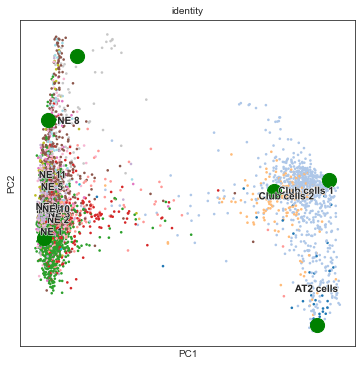

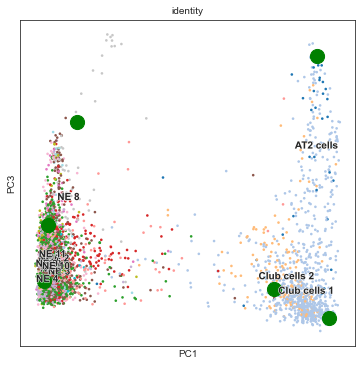

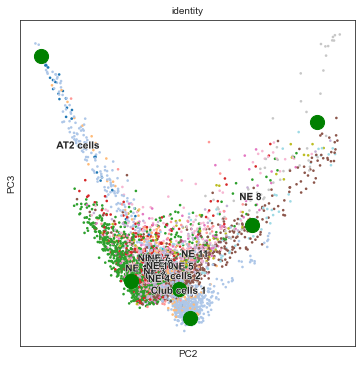

In [101]:
XC6, S6, C6, SSE6, varexpl6 = PCHA(X_magic.obsm['X_pca'][:,0:8].T, noc=6, delta=0)
XC6 = np.array(XC6)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'identity', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC6[int(comp[0])-1], XC6[int(comp[1])-1], color = 'green', s = 200)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

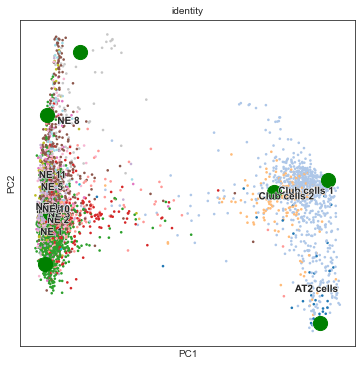

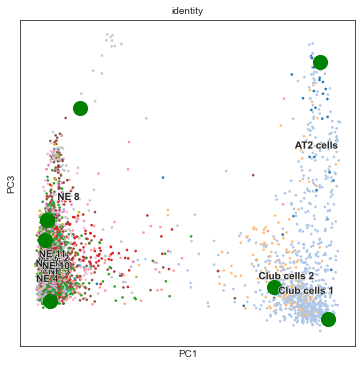

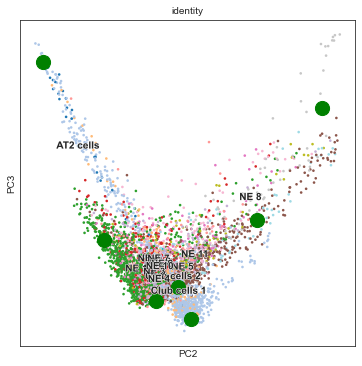

In [102]:
XC7, S7, C7, SSE7, varexpl7 = PCHA(X_magic.obsm['X_pca'][:,0:8].T, noc=7, delta=0)
XC7 = np.array(XC7)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'identity', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC7[int(comp[0])-1], XC7[int(comp[1])-1], color = 'green', s = 200)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

In [3]:
adata = sc.read_h5ad('../../data/M2/adata_02_filtered.h5ad')

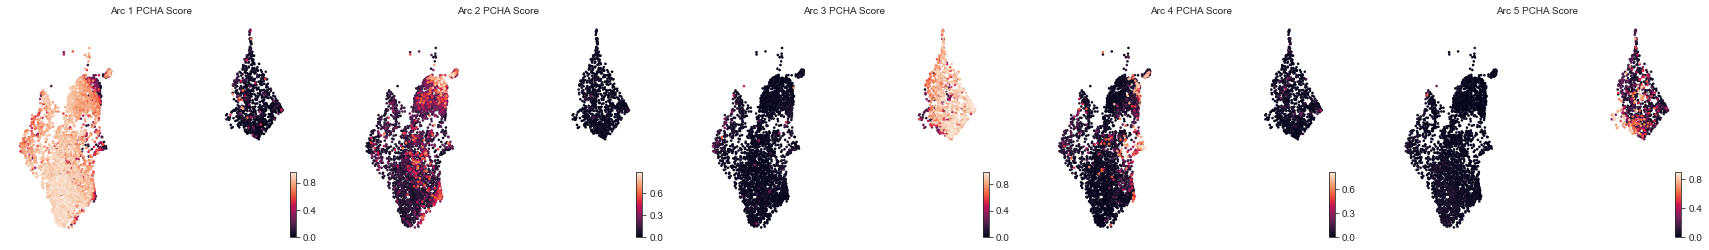

In [4]:
scv.pl.scatter(adata, color = [i for i in adata.obs.columns if i.endswith('_Score')], smooth = True, basis = 'umap_wnn', ncols = 6, cmap = 'rocket')
